# 猫狗识别
使用Kaggle的数据集，训练模型，识别猫狗。使用卷积神经网络

## 对数据进行预处理，使用1000张图片的小训练集。验证集500张图片，测试集1000张图片

In [26]:
import os, shutil, pathlib

origin_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cat_vs_dogs_small")

# 创建一个实用函数，将索引从start_index到end_index的猫/狗图片复制到子目录new_base_dir/{subset_name}/cat(或/dog)下。
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=origin_dir / fname, 
                            dst= dir / fname)
            
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

FileNotFoundError: [Errno 2] No such file or directory: 'train/cat.88.jpg'

> 使用Kimi重新改进了这个函数，没有的直接跳过，不报错，继续执行

In [27]:
import os
import shutil
from pathlib import Path

origin_dir = Path("train")
new_base_dir = Path("cat_vs_dogs_small")

# 创建一个实用函数，将索引从start_index到end_index的猫/狗图片复制到子目录new_base_dir/{subset_name}/cat(或/dog)下。
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        # 创建目标目录
        target_dir = new_base_dir / subset_name / category
        target_dir.mkdir(parents=True, exist_ok=True)  # 使用mkdir代替os.makedirs，增加exist_ok参数

        # 构建文件名列表
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # 遍历文件名列表并复制文件
        for fname in fnames:
            src_path = origin_dir / fname
            dst_path = target_dir / fname

            # 检查源文件是否存在
            if not src_path.exists():
                print(f"文件 {src_path} 不存在，跳过复制。")
                continue  # 文件不存在，跳过当前循环

            # 复制文件
            shutil.copyfile(src=src_path, dst=dst_path)
            print(f"文件 {fname} 已复制到 {target_dir}")

# 调用函数以创建子集
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

文件 cat.0.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.1.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.2.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.3.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.4.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.5.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.6.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.7.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.8.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.9.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.10.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.11.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.12.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.13.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.14.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.15.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.16.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.17.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.18.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.19.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.20.jpg 已复制到 cat_vs_dogs_small/train/cat
文件 cat.21.jpg 已复制到 cat_

### 上面通过python脚本，实现了小样本数据集，接下来对数据进行预处理
1. 读取jpg文件
2. 将文件解码为RGB像素网格
3. 将像素网格转换为浮点数张量
4. 将张量调增为相同大小，在这个卷积神经网络中为180 * 180
5. 将数据打包成批量，一个批量包含32张图片

Keras包含实用函数image_dataset_from_directory(),可以快速建立数据管道，自动将磁盘上的图像文件转换为预处理好的张量批量


In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 1608 files belonging to 2 classes.
Found 772 files belonging to 2 classes.
Found 1599 files belonging to 2 classes.


## 构建一个神经网络

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

# 模型输入是180 * 180的RGB图像
inputs = keras.Input(shape=(180, 180, 3))
# 把输入除以255，使其缩放至[0, 1]区间
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 利用Dataset拟合模型

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


In [33]:
history = model.fit(
    train_dataset,
    epochs = 30, 
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 495ms/step - accuracy: 0.5098 - loss: 0.7853 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.5184 - loss: 0.7025 - val_accuracy: 0.5816 - val_loss: 0.6864
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 535ms/step - accuracy: 0.5560 - loss: 0.6918 - val_accuracy: 0.5337 - val_loss: 0.6842
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 580ms/step - accuracy: 0.5602 - loss: 0.6846 - val_accuracy: 0.5946 - val_loss: 0.6559
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 551ms/step - accuracy: 0.6211 - loss: 0.6589 - val_accuracy: 0.6619 - val_loss: 0.6089
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 565ms/step - accuracy: 0.6666 - loss: 0.6321 - val_accuracy: 0.6684 - val_loss: 0.6278
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 572ms/step - accuracy: 0.6814 - loss: 0.6020 - val_accuracy: 0.6943 - val_loss: 0.5675
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - accuracy: 0.7031 - loss: 0.5808 - val_accu

绘制精度曲线和损失曲线

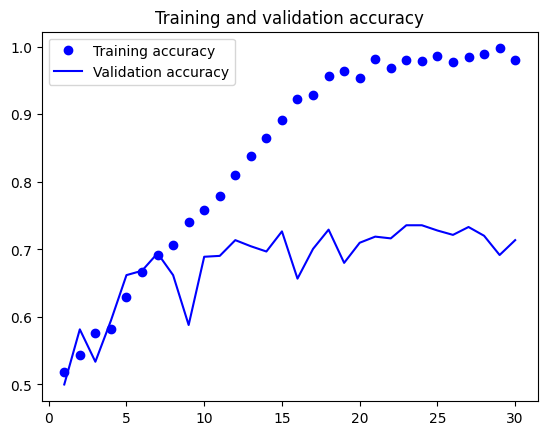

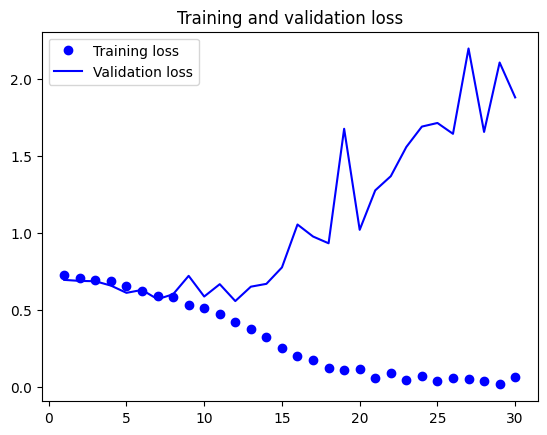

In [35]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.6943 - loss: 0.6117
Test accuracy: 0.690
